Mounted at /content/gdrive
Generation #1 best cost: 136.38577318191528, avg cost: 169.8752474784851, path: [3, 4, 11, 9, 5, 14, 2, 0, 13, 8, 6, 7, 1, 10, 12]
Generation #2 best cost: 133.41959929466248, avg cost: 169.8752474784851, path: [1, 10, 7, 6, 13, 0, 8, 2, 9, 14, 5, 11, 4, 3, 12]
Generation #3 best cost: 132.852721452713, avg cost: 153.78347444534302, path: [6, 13, 0, 8, 2, 9, 14, 5, 11, 4, 3, 7, 10, 1, 12]
Generation #4 best cost: 132.852721452713, avg cost: 142.4445686340332, path: [6, 13, 0, 8, 2, 9, 14, 5, 11, 4, 3, 7, 10, 1, 12]
Generation #5 best cost: 132.852721452713, avg cost: 149.7806270122528, path: [6, 13, 0, 8, 2, 9, 14, 5, 11, 4, 3, 7, 10, 1, 12]
Generation #6 best cost: 128.11910963058472, avg cost: 175.15412259101868, path: [5, 14, 9, 2, 8, 0, 13, 6, 7, 10, 1, 12, 3, 4, 11]
Generation #7 best cost: 128.11910963058472, avg cost: 137.01370239257812, path: [5, 14, 9, 2, 8, 0, 13, 6, 7, 10, 1, 12, 3, 4, 11]
Generation #8 best cost: 128.11910963058472, avg cost: 147.

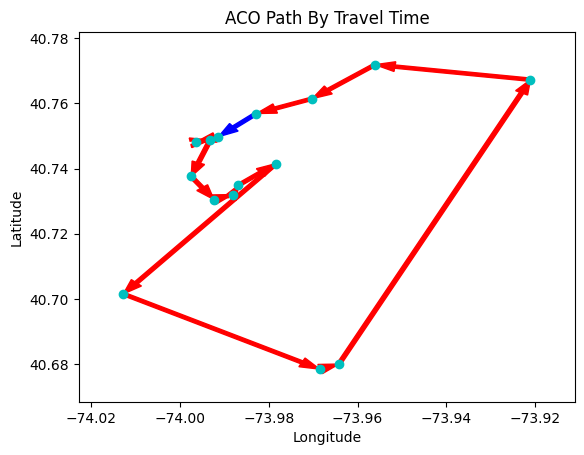

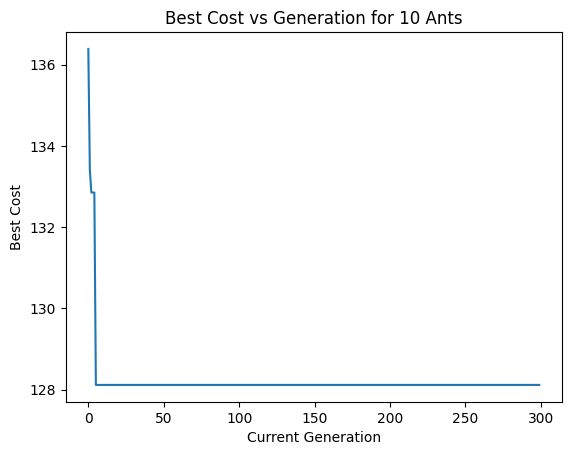

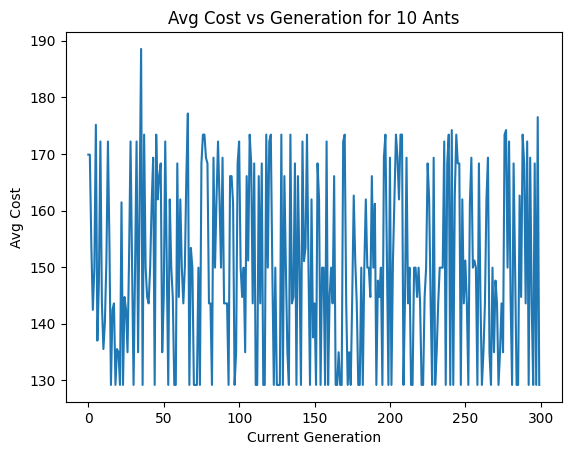

In [16]:
from google.colab import drive
drive.mount('/content/gdrive')

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import pickle
from geopy.exc import GeocoderTimedOut
from geopy.geocoders import Nominatim
import xgboost as xgb
import pprint


class Graph(object):
    def __init__(self, cost_matrix: list, rank: int):
        """
        :param cost_matrix:
        :param rank: rank of the cost matrix
        """
        self.matrix = cost_matrix
        self.rank = rank
        self.pheromone = [[1 / (rank * rank)
                           for j in range(rank)] for i in range(rank)]


class ACO(object):
    def __init__(self, ant_count: int, generations: int, alpha: float, beta: float, rho: float, q: int,
                 strategy: int):
        """
        :param ant_count:
        :param generations:
        :param alpha: relative importance of pheromone
        :param beta: relative importance of heuristic information
        :param rho: pheromone residual coefficient
        :param q: pheromone intensity
        :param strategy: pheromone update strategy. 0 - ant-cycle, 1 - ant-quality, 2 - ant-density
        """
        self.Q = q
        self.rho = rho
        self.beta = beta
        self.alpha = alpha
        self.ant_count = ant_count
        self.generations = generations
        self.update_strategy = strategy

    def _update_pheromone(self, graph: Graph, ants: list):
        for i, row in enumerate(graph.pheromone):
            for j, col in enumerate(row):
                graph.pheromone[i][j] *= self.rho
                for ant in ants:
                    graph.pheromone[i][j] += ant.pheromone_delta[i][j]

    # noinspection PyProtectedMember
    def solve(self, graph: Graph, verbose: bool = False):
        """
        :param graph:
        """
        best_cost = float('inf')
        best_solution = []
        avg_costs = []
        best_costs = []
        for gen in range(self.generations):
            # noinspection PyUnusedLocal
            ants = [_Ant(self, graph) for i in range(self.ant_count)]
            for ant in ants:
                curr_cost = []
                for i in range(graph.rank - 1):
                    ant._select_next()
                ant.total_cost += graph.matrix[ant.tabu[-1]][ant.tabu[0]]
                curr_cost.append(ant.total_cost)
                if ant.total_cost < best_cost:
                    best_cost = ant.total_cost
                    best_solution = [] + ant.tabu
                # update pheromone
                ant._update_pheromone_delta()
            self._update_pheromone(graph, ants)
            best_costs.append(best_cost)
            avg_costs.append(np.mean(curr_cost))
            if "store_true":
                print('Generation #{} best cost: {}, avg cost: {}, path: {}'.format(
                    gen+1, best_cost, avg_costs[-1], best_solution))
        return best_solution, best_cost, avg_costs, best_costs


class _Ant(object):
    def __init__(self, aco: ACO, graph: Graph):
        self.colony = aco
        self.graph = graph
        self.total_cost = 0.0
        self.tabu = []  # tabu list
        self.pheromone_delta = []  # the local increase of pheromone
        # nodes which are allowed for the next selection
        self.allowed = [i for i in range(graph.rank)]
        self.eta = [[0 if i == j else 1 / graph.matrix[i][j] for j in range(graph.rank)] for i in
                    range(graph.rank)]  # heuristic information
        start = random.randint(0, graph.rank - 1)  # start from any node
        self.tabu.append(start)
        self.current = start
        self.allowed.remove(start)

    def _select_next(self):
        denominator = 0
        for i in self.allowed:
            denominator += self.graph.pheromone[self.current][i] ** self.colony.alpha * self.eta[self.current][
                i] ** self.colony.beta
        # noinspection PyUnusedLocal
        # probabilities for moving to a node in the next step
        probabilities = [0 for i in range(self.graph.rank)]
        for i in range(self.graph.rank):
            try:
                self.allowed.index(i)  # test if allowed list contains i
                probabilities[i] = self.graph.pheromone[self.current][i] ** self.colony.alpha * \
                    self.eta[self.current][i] ** self.colony.beta / denominator
            except ValueError:
                pass  # do nothing
        # select next node by probability roulette
        selected = 0
        rand = random.random()
        for i, probability in enumerate(probabilities):
            rand -= probability
            if rand <= 0:
                selected = i
                break
        self.allowed.remove(selected)
        self.tabu.append(selected)
        self.total_cost += self.graph.matrix[self.current][selected]
        self.current = selected

    # noinspection PyUnusedLocal
    def _update_pheromone_delta(self):
        self.pheromone_delta = [
            [0 for j in range(self.graph.rank)] for i in range(self.graph.rank)]
        for _ in range(1, len(self.tabu)):
            i = self.tabu[_ - 1]
            j = self.tabu[_]
            if self.colony.update_strategy == 1:  # ant-quality system
                self.pheromone_delta[i][j] = self.colony.Q
            elif self.colony.update_strategy == 2:  # ant-density system
                # noinspection PyTypeChecker
                self.pheromone_delta[i][j] = self.colony.Q / \
                    self.graph.matrix[i][j]
            else:  # ant-cycle system
                self.pheromone_delta[i][j] = self.colony.Q / self.total_cost


filename = "gdrive/My Drive/Meta Heuristic/xgb_model.sav"
loaded_model = pickle.load(open(filename, 'rb'))
geolocator = Nominatim(user_agent="aco-application")


def time_cost_between_points(loc1, loc2, passenger_count, store_and_fwd_flag=0):
    """
    Calculate the time (in minutes) between two points
    using the trained XGB model
    """
    # Hardcode the date to get consistent calculations
    date_list = [27, 5, 2016]  # May 27, 2016

    year = int(date_list[2])
    month = int(date_list[1])
    day = int(date_list[0])

    my_date = datetime.date(year, month, day)

    model_data = {'passenger_count': passenger_count,
                  'pickup_longitude': loc1['x'],
                  'pickup_latitude': loc1['y'],
                  'dropoff_longitude': loc2['x'],
                  'dropoff_latitude': loc2['y'],
                  'store_and_fwd_flag': bool(store_and_fwd_flag),
                  'pickup_month': my_date.month,
                  'pickup_day': my_date.day,
                  'pickup_weekday': my_date.weekday(),
                  'pickup_hour': 23,
                  'pickup_minute': 10,
                  'latitude_difference': loc2['y'] - loc1['y'],
                  'longitude_difference': loc2['x'] - loc1['x'],
                  'trip_distance': trip_distance_cost(loc1, loc2)
                  }

    df = pd.DataFrame([model_data], columns=model_data.keys())
    pred = np.exp(loaded_model.predict(xgb.DMatrix(df))) - 1
    return pred[0]


def trip_distance_cost(loc1, loc2):
    """
    Calculate the manhattan distance between two points using 
    polar coordinates in taxicab geometry https://en.wikipedia.org/wiki/Taxicab_geometry
    """
    return 0.621371 * 6371 * (
        abs(2 * np.arctan2(np.sqrt(np.square(
            np.sin((abs(loc2['y'] - loc1['y']) * np.pi / 180) / 2))),
            np.sqrt(1-(np.square(np.sin((abs(loc2['y'] - loc1['y']) * np.pi / 180) / 2)))))) +
        abs(2 * np.arctan2(np.sqrt(np.square(np.sin((abs(loc2['x'] - loc1['x']) * np.pi / 180) / 2))),
                           np.sqrt(1-(np.square(np.sin((abs(loc2['x'] - loc1['x']) * np.pi / 180) / 2)))))))



loc_count= 15
ant_count= 10
g= 300 #number of generations
alpha =1.0 #relative importance of pheromone
beta =10.0 #relative importance of heuristic information
rho =0.5 #pheromone residual coefficient
q =10.0 #pheromone intensity

locations = []
points = []
# Read in the user specified number of lines from the test data
df = pd.read_csv('gdrive/My Drive/Meta Heuristic/test.csv')[:loc_count]
for index, row in df.iterrows():
    locations.append({
        'index': index,
        'x': row['pickup_longitude'],
        'y': row['pickup_latitude']
    })
    points.append((row['pickup_longitude'], row['pickup_latitude']))

# Build complete cost matrix based on time between points
cost_matrix = []
rank = len(locations)
for i in range(rank):
    row = []
    for j in range(rank):
        row.append(time_cost_between_points(
            locations[i], locations[j],
            1, 0))
    cost_matrix.append(row)

# Pass in user arguments
aco = ACO(ant_count, g, alpha,beta, rho, q, strategy=2)

# Build graph with cost matrix and number of points
graph = Graph(cost_matrix, rank)
# Get results from ant colony, specify whether verbose output
best_path, cost, avg_costs, best_costs = aco.solve(graph, "store_true")

# Print out and plot final solution
print('Final cost: {} minutes, path: {}'.format(cost, best_path))

# Output the mean and standard deviantion of min costs per generation
print("Min cost mean:", np.mean(best_costs))
print("Min cost standard deviation:", np.std(best_costs))

# Print out final addresses in solution
if "store_true":
    print("Final path addresses:")
    try:
        addresses = []
        for p in best_path:
            addresses.append(geolocator.reverse(
                f"{points[p][1]}, {points[p][0]}").address)
        pprint.pprint(addresses)
    except GeocoderTimedOut as e:
        print(f"Error: geocode failed with message {e}")

x = []
y = []
for point in points:
    x.append(point[0])
    y.append(point[1])
plt.plot(x, y, 'co')

for _ in range(1, len(best_path)):
    i = best_path[_ - 1]
    j = best_path[_]
    plt.arrow(x[i], y[i], x[j] - x[i], y[j] - y[i],
              color='r', length_includes_head=True)

# Close the loop and highlight the last and first point path
i = best_path[-1]  # Last point index
j = best_path[0]  # First point index
plt.arrow(x[i], y[i], x[j] - x[i], y[j] - y[i],
          color='b', length_includes_head=True)

zoom_factor = 0.01
plt.xlim(min(x) - zoom_factor, max(x) + zoom_factor)
plt.ylim(min(y) - zoom_factor, max(y) + zoom_factor)
plt.title("ACO Path By Travel Time")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


x_values = [i for i in range(g)]
plt.title("Best Cost vs Generation for " + str(ant_count) + " Ants")
plt.ylabel("Best Cost")
plt.xlabel("Current Generation")
plt.plot(x_values, best_costs)
plt.show()

x_values = [i for i in range(g)]
plt.title("Avg Cost vs Generation for " + str(ant_count) + " Ants")
plt.ylabel("Avg Cost")
plt.xlabel("Current Generation")
plt.plot(x_values, avg_costs)
plt.show()

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

import pandas as pd
import numpy as np
import xgboost as xgb
import pickle
from geopy.geocoders import Nominatim
from sklearn.model_selection import train_test_split

pd.set_option('display.max_columns', None)

def featureEngineer(data):
    '''
    Function to pre-process and engineer features of the train data
    '''
    # Convert character variables to numeric
    f = lambda x: 0 if x == 'N' else 1
    data["store_and_fwd_flag"] = data["store_and_fwd_flag"].apply(lambda x: f(x))

    # Convert datetime strings into datetime
    data["dropoff_datetime"] = pd.to_datetime(data["dropoff_datetime"], format='%Y-%m-%d %H:%M:%S')
    data["pickup_datetime"] = pd.to_datetime(data["pickup_datetime"], format='%Y-%m-%d %H:%M:%S')

    # Now construct other variables, like month, date, etc.
    data["pickup_month"] = data["pickup_datetime"].dt.month
    data["pickup_day"] = data["pickup_datetime"].dt.day
    data["pickup_weekday"] = data["pickup_datetime"].dt.weekday
    data["pickup_hour"] = data["pickup_datetime"].dt.hour
    data["pickup_minute"] = data["pickup_datetime"].dt.minute

    # Get latitude and longitude differences
    data["latitude_difference"] = data["dropoff_latitude"] - data["pickup_latitude"]
    data["longitude_difference"] = data["dropoff_longitude"] - data["pickup_longitude"]

    # Convert duration to minutes for easier interpretation
    data["trip_duration"] = data["trip_duration"].apply(lambda x: round(x/60))


    # Convert trip distance from longitude and latitude differences to Manhattan distance.
    data["trip_distance"] = 0.621371 * 6371 *(abs(2 * np.arctan2(
            np.sqrt(
                np.square(np.sin((abs(data["latitude_difference"]) * np.pi / 180) / 2))
            ), np.sqrt(
                1 - (np.square(np.sin((abs(data["latitude_difference"]) * np.pi / 180) / 2)))
            )
        )) +
        abs(2 * np.arctan2(
            np.sqrt(
                np.square(np.sin((abs(data["longitude_difference"]) * np.pi / 180) / 2))
            ), np.sqrt(
                1 - (np.square(np.sin((abs(data["longitude_difference"]) * np.pi / 180) / 2)))
            )
        )))

def rmsle(y_true, y_pred):
    '''
    Function to define evaluation metric
    >> Input: y_true -- ground truth labels, y_pred -- predicted labels
    >> Output: evaluation metric
    '''
    assert len(y_true) == len(y_pred)
    return np.square(np.log(y_pred + 1) - np.log(y_true + 1)).mean() ** 0.5

def XGBmodel(X, y):
    '''
    Function to train a XGBoost machine learning model on the data
    >> Input: X -- features, y -- label
    >> Output:
    '''
    # Split the train data into training, test, and valdiation sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2019)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=2019)

    # XGBoost parameters
    params = {
        'booster':            'gbtree',
        'objective':          'reg:linear',
        'learning_rate':      0.05,
        'max_depth':          14,
        'subsample':          0.9,
        'colsample_bytree':   0.7,
        'colsample_bylevel':  0.7,
        'silent':             1,
        'feval':              'rmsle'
    }

    # Define train and validation sets
    dtrain = xgb.DMatrix(X_train, np.log(y_train+1))
    dval = xgb.DMatrix(X_val, np.log(y_val+1))

    # this is for tracking the error
    watchlist = [(dval, 'eval'), (dtrain, 'train')]

    # Number of training rounds
    nrounds = 1000

    # Train model
    gbm = xgb.train(params, dtrain, num_boost_round = nrounds, evals = watchlist, verbose_eval = True)

    # Test predictions
    y_pred = np.exp(gbm.predict(xgb.DMatrix(X_test))) - 1

    # Use mean absolute error to get a basic estimate of the error
    mae = (abs(y_pred - y_test)).mean()

    # Take a look at feature importance
    feature_scores = gbm.get_fscore()
    # Feature scaling
    summ = 0
    for key in feature_scores:
        summ = summ + feature_scores[key]
    for key in feature_scores:
        feature_scores[key] = feature_scores[key] / summ

    print('Mean Absolute Error:', mae)
    print('Feature Importance:', feature_scores)

    return gbm

if __name__ == '__main__':
    # Read train file
    taxiDB = pd.read_csv('gdrive/My Drive/Meta Heuristic/train.csv')

    # Engineer features
    featureEngineer(taxiDB)

    # Get features and labels for the data
    X = taxiDB.drop(["trip_duration", "id", "vendor_id", "pickup_datetime", "dropoff_datetime"], axis=1)
    y = taxiDB["trip_duration"]

    # Train XGB Model to our data
    model = XGBmodel(X, y)
    filename = "xgb_model.sav"
    pickle.dump(model, open(filename, 'wb'))

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
[13:32:56] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[13:32:56] WARNING: ../src/learner.cc:767: 
Parameters: { "feval", "silent" } are not used.

[0]	eval-rmse:2.00760	train-rmse:2.00418
[1]	eval-rmse:1.91128	train-rmse:1.90783
[2]	eval-rmse:1.81984	train-rmse:1.81634
[3]	eval-rmse:1.73358	train-rmse:1.73006
[4]	eval-rmse:1.65178	train-rmse:1.64818
[5]	eval-rmse:1.57382	train-rmse:1.57009
[6]	eval-rmse:1.50006	train-rmse:1.49625
[7]	eval-rmse:1.43046	train-rmse:1.42653
[8]	eval-rmse:1.36423	train-rmse:1.36023
[9]	eval-rmse:1.30155	train-rmse:1.29737
[10]	eval-rmse:1.24221	train-rmse:1.23778
[11]	eval-rmse:1.18610	train-rmse:1.18151
[12]	eval-rmse:1.13329	train-rmse:1.12848
[13]	eval-rmse:1.08299	train-rmse:1.07795
[14]	eval-rmse:1.03567	train-rmse:1.03034
[15]	eval-rmse:0.99177	train-rmse:0.9